In [44]:
import rasterio.mask

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio

from pathlib import Path

In [ ]:
agebs = gpd.read_file(r"C:\Users\lain\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\population_grids_data\final\reprojected\merged\02.2.03.gpkg").to_crs("ESRI:54009")
# blocks = gpd.read_file(r"C:\Users\lain\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\population_grids_data\final\framework\agebs\2020.gpkg")
blocks = gpd.read_file(r"C:\Users\lain\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\mexicali_data\lim_cols_cp\lim_cols_cp.shp").to_crs(agebs.crs).drop(columns=["CVEGEO"]).reset_index(names="CVEGEO")


In [51]:
idx_map = {
    1: 1924,
    2: 1932,
    3: 1944,
    4: 1960,
    5: 1970,
    6: 1980,
    7: 1990,
    8: 2000,
    9: 2010,
}

df_urb = (
    gpd.read_file(r"C:\Users\lain\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\mexicali_data\urb_hist.gpkg").dropna(subset=["geometry"])
    .to_crs(blocks.crs)
    .assign(urb_year=lambda df: df["idx"].map(idx_map))
    .drop(columns=["idx"])
)

In [9]:
joined = blocks.sjoin(agebs, how="inner", predicate="intersects").drop_duplicates(subset=["CVEGEO"])

In [62]:
built_path = Path(r"C:\Users\lain\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\GHSL_GLOBAL\BUILT_100")

area_fracs = [[] for _ in range(len(joined))]
for year in range(1975, 2021, 5):
    with rio.open(built_path / f"{year}.tif") as ds:
        for i, geom in enumerate(joined["geometry"]):
            masked, _ = rio.mask.mask(ds, [geom], crop=True, nodata=65335)
            masked = masked.astype(float)
            masked[masked == 65335] = np.nan
            area_frac = np.nansum(masked) / (masked.size * 10_000)
            area_fracs[i].append(area_frac)

urb_years = []
for elem in area_fracs:
    elem = np.array(elem)
    is_urbanized = elem > 0.05
    if is_urbanized.any():
        urb_years.append(np.argmax(is_urbanized))
    else:
        urb_years.append(np.nan)

temp = joined.copy()
temp["urb_year"] = np.array(urb_years) * 5 + 1975
temp = temp.drop(columns=["index_right"])

In [ ]:
temp_trimmed = temp.loc[~temp.index.isin(temp.sjoin(df_urb[["geometry"]], how="inner", predicate="intersects").index.unique()), ["urb_year", "geometry"]]

df_plot = pd.concat([temp_trimmed, df_urb], ignore_index=True).dropna(subset=["urb_year"]).reset_index(drop=True)
df_plot.to_file("./urb.gpkg")

In [81]:
for year in sorted(df_plot["urb_year"].unique()):
    fig, ax = plt.subplots(figsize=(14, 7))
    df_plot.query("urb_year<=@year").plot(column="urb_year", cmap="viridis", legend=True, figsize=(10, 10), edgecolor="black", ax=ax, vmin=df_plot["urb_year"].min(), vmax=df_plot["urb_year"].max())
    ax.set_ylim(3.94e6, 3.956e6)
    ax.set_xlim(-1.0415e7, -1.039e7)
    ax.axis("off")
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=13, crs=temp.crs.to_proj4())
    fig.savefig(f"./fig/{int(year)}.jpg", bbox_inches="tight", dpi=200)
    plt.close()

c:\Users\lain\Documents\mexicali-zone\.venv\Lib\site-packages\pyproj\crs\crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
c:\Users\lain\Documents\mexicali-zone\.venv\Lib\site-packages\pyproj\crs\crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
c:\Users\lain\Documents\mexicali-zone\.venv\Lib\site-packages\pyproj\crs\crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-

(-10415000.0, -10390000.0)

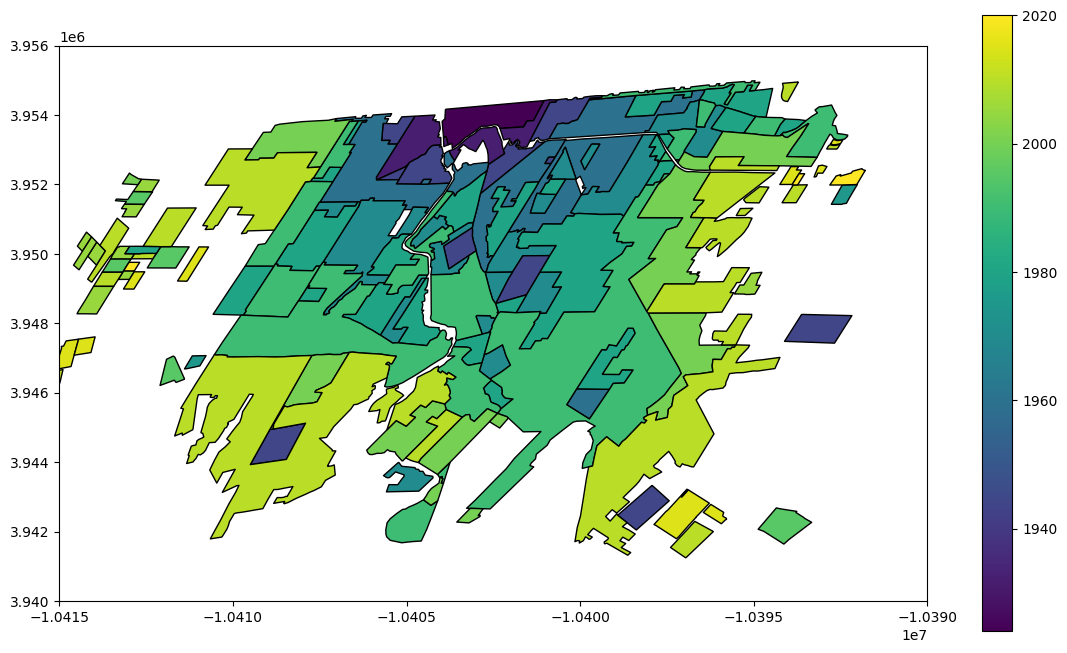

In [67]:
fig, ax = plt.subplots(figsize=(14, 8))
# df_
df_plot.plot(column="urb_year", cmap="viridis", legend=True, figsize=(10, 10), edgecolor="black", ax=ax)
ax.set_ylim(3.94e6, 3.956e6)
ax.set_xlim(-1.0415e7, -1.039e7)
# cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=13, crs=temp.crs.to_proj4())